In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import torch.utils.data
from torch.utils.data import DataLoader
from collections import Counter

from utils import EmotionsDataset, AttentionalNet
import sklearn.preprocessing as sk_prep
from PIL import Image


In [3]:
# define dictionary for emotions
emotion_dict = {0: 'Angry', 
                1: 'Disgust', 
                2: 'Fear',
                3: 'Happy', 
                4: 'Sad',
                5: 'Surprise',
                6: 'Neutral'}

In [19]:
def load_data(file_name):
    data = pd.read_csv(file_name)
    y = data['emotion'].values
    x = data[' pixels'].str.split(' ', expand=True)
    x = x.astype(int).values
    return x, y


def split_data(x, y, ratio):
    n = len(x)
    
    ix_train = int(ratio[0] * n)
    ix_valid = ix_train + int(ratio[1] * n)
    
    x_train = x[: ix_train, :]
    y_train = y[: ix_train, ]

    x_valid = x[ix_train : ix_valid, :]
    y_valid = y[ix_train : ix_valid, ]
    
    x_test = x[ix_valid:, :]
    y_test = y[ix_valid:, ]


    return x_train, y_train, x_valid, y_valid, x_test, y_test

class CustomImageDataset():
    def __init__(self, 
                 x, 
                 y, 
                 transform = None,
                 target_transform = None,
                 seed: int = 123456789):
        
        self.transform = transform
        self.target_transform = transform
        
        self.rng = np.random.default_rng(seed=seed)
        self.g_cpu = torch.Generator()
        self.g_cpu.manual_seed(seed)
        self.train_idxs = None

        self.targets = y
        self.data = x.reshape(-1, 1, 48, 48)  # one channel, 48x48 image
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        img, target = self.data[idx], self.targets[idx]
        img = Image.fromarray(img.reshape(48, 48))
        
        if self.transform is not None:
            img = self.transform(img)
            #target = self.target_transform(target)

        return img, target
    


In [14]:
x, y = load_data('../dataset/icml_face_data.csv')

x_train, y_train, _, _, x_test, y_test = split_data(x, y, ratio=(0.8, 0, 0.2))


robust_scaler = sk_prep.RobustScaler()
robust_scaler.fit(x_train)
x_train_robust = robust_scaler.transform(x_train)
x_test_robust = robust_scaler.transform(x_test)
        
normalization = sk_prep.Normalizer()
normalization.fit(x_train_robust)
x_train_robust_norm = normalization.transform(x_train_robust)
x_test_robust_norm = normalization.transform(x_test_robust)


batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])
dataset_train = CustomImageDataset(x_train_robust_norm, y_train, transform=transform)
dataset_test = CustomImageDataset(x_test_robust_norm, y_test, transform=transform)


trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
testloader = DataLoader(dataset_test, batch_size=batch_size)

batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
dataset_train = EmotionsDataset(root='./data', fname='icml_face_data_train.csv', transform=transform)
dataset_test = EmotionsDataset(root='./data', fname='icml_face_data_test.csv', transform=transform)

trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
testloader = DataLoader(dataset_test, batch_size = batch_size)

In [15]:
class Face_Emotion_CNN(nn.Module):
    def __init__(self):
        super(Face_Emotion_CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5,padding=3)
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4,padding=2)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5,padding=3)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128,kernel_size=5,padding=3)

        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(3,stride=2)
        self.cnn1_bn = nn.BatchNorm2d(32)
        self.cnn2_bn = nn.BatchNorm2d(32)
        self.cnn3_bn = nn.BatchNorm2d(64)
        self.cnn4_bn = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128*3*3, 1024)
        self.fc2 = nn.Linear(1024, 7)
        self.dropout = nn.Dropout(0.3)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.relu(self.pool(self.cnn1_bn(self.cnn1(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn2_bn(self.cnn2(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn3_bn(self.cnn3(x))))
        #print(x.shape)
        x = self.relu(self.pool(self.cnn4_bn(self.cnn4(x))))
        #print(x.shape)

        #x = x.view(x.size(0), -1)
        x = x.reshape(x.shape[0],128*3*3)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(self.dropout(x)))
        x = self.log_softmax(x)
        return x

model = Face_Emotion_CNN()

In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

#class_count = [i for i in Counter(dataset_train.targets).values()]
#weight = torch.tensor(class_count) / sum(class_count)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [20]:
no_epochs = 20
training_loss = []
test_loss = []
test_acc = []
train_acc = []

for epoch in range(no_epochs): 
    running_loss = 0.0
    running_loss_test = 0
    running_loss_train = 0
    correct_test = 0
    total_test = 0
    total_train = 0 
    correct_train = 0
    print(f"Epoch {epoch+1}")
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #if i % 2000 == 1999:    # print every 2000 mini-batches
            #print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

    with torch.no_grad():
        for traindata in trainloader:
            trainimages, trainlabels = traindata
            trainoutputs = model(trainimages)
            loss_train = criterion(trainoutputs, trainlabels)
            running_loss_train += loss_train.item()
            train_, trainpredicted = torch.max(trainoutputs.data, 1)
            total_train += trainlabels.size(0)
            correct_train += (trainpredicted == trainlabels).sum().item()
            
    with torch.no_grad():
        for testdata in testloader:
            testimages, testlabels = testdata
            testoutputs = model(testimages)
            loss_test = criterion(testoutputs, testlabels)
            running_loss_test += loss_test.item()
            test_, testpredicted = torch.max(testoutputs.data, 1)
            total_test += testlabels.size(0)
            correct_test += (testpredicted == testlabels).sum().item()
    
    print(correct_test/total_test)
    training_loss.append(running_loss)
    test_loss.append(running_loss_test)
    test_acc.append(correct_test/total_test)
    train_acc.append(correct_train/total_train)

print('Finished Training')

0.46628587350236833
0.48578991362496515
0.5433268319866258
0.530231262190025
0.5657564781276121
0.5674282529952633
0.5628308721092227
0.5869322931178601
0.5845639453886876


KeyboardInterrupt: 

In [9]:
PATH = '../experiments/Kim_model_new_layer_20epoch_mmr_2.pth'
torch.save(model.state_dict(), PATH)

In [10]:
model = Face_Emotion_CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 54 %


In [12]:
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Angry is 58.4 %
Accuracy for class: Disgust is 0.0 %
Accuracy for class: Fear  is 10.7 %
Accuracy for class: Happy is 76.3 %
Accuracy for class: Sad   is 55.8 %
Accuracy for class: Surprise is 68.8 %
Accuracy for class: Neutral is 48.7 %


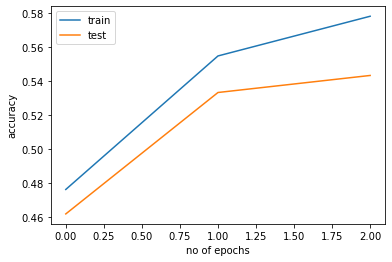

In [13]:
#plt.plot(training_loss)
plt.ylabel("accuracy")
plt.xlabel("no of epochs")
plt.plot(train_acc,label="train")
plt.plot(test_acc,label="test")
plt.legend(["train","test"])


<AxesSubplot:>

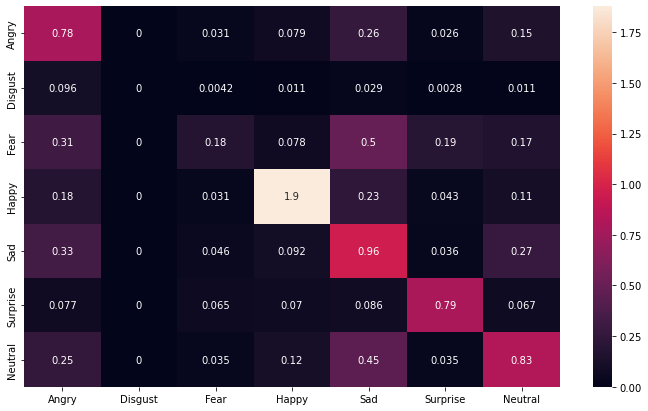

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [15]:
cf_matrix

array([[ 562,    0,   22,   57,  189,   19,  109],
       [  69,    0,    3,    8,   21,    2,    8],
       [ 224,    0,  129,   56,  357,  139,  119],
       [ 127,    0,   22, 1348,  168,   31,   78],
       [ 238,    0,   33,   66,  687,   26,  197],
       [  55,    0,   47,   50,   62,  569,   48],
       [ 181,    0,   25,   83,  325,   25,  594]], dtype=int64)